In [1]:
import os
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import PorterStemmer
from keras.layers import Flatten
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train['label'] = train.label.replace({'positive':2,'negative':0,'neutral':1})
test['label'] = test.label.replace({'positive':2,'negative':0,'neutral':1})
df_tr, df_val = train_test_split(train, test_size=0.2)

In [3]:
# Function for the pre-processing
def preprocess_text(text):
    # Conversion to the lowercase.
    text = text.lower()
    # Remove all the special characters.
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove all the stop words (and, or, with)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Stemmize and Lemmatize
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return ' '.join(stemmed_tokens)

# Apply preprocessing on the text
train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

In [4]:
# Define training variables
# Training
X = train['text']
y = train['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Testing
X_test = test['text']
y_test = test['label']

In [22]:
# Input preperation for neural networks
# Tokenization
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train)
wi = tokenizer.word_index

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)
# Padding for embedding layer
sequence_len = 50
X_train_token = pad_sequences(X_train_token, padding='post', maxlen=sequence_len)
X_test_token = pad_sequences(X_test_token, padding='post', maxlen=sequence_len)



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3443 - loss: 1.1091 - val_accuracy: 0.4563 - val_loss: 1.0646
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4916 - loss: 1.0524 - val_accuracy: 0.4521 - val_loss: 1.0420
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5210 - loss: 1.0108 - val_accuracy: 0.5833 - val_loss: 0.9906
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8411 - loss: 0.8397 - val_accuracy: 0.6354 - val_loss: 0.9057
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9714 - loss: 0.5841 - val_accuracy: 0.6771 - val_loss: 0.8404
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9948 - loss: 0.4136 - val_accuracy: 0.7083 - val_loss: 0.7879
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9995 - loss: 0.2917 - val_accuracy: 0.7125 - val_loss: 0.7465
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 0.2054 - val_accuracy: 0.7125

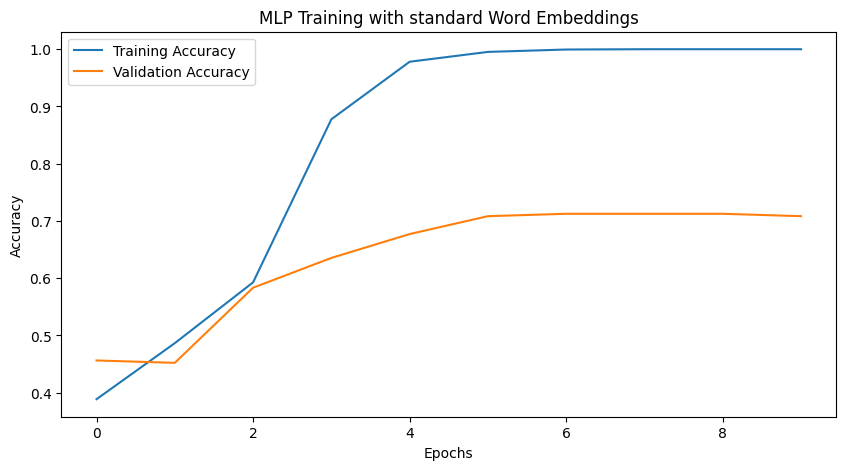

In [23]:
# MLP definition
# Embedding Layer (Essential for NLP using Neural Networks)
max_length = max([len(s.split()) for s in X_train])
vocab_size = len(tokenizer.index_word) + 1
embedding_dim = 50 # Must match sequence_len defined in the previous block
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=max_length))
# Flatten Layer (essential to prepare data from embedding layer to dense layer)
model.add(Flatten())
# Hidden Layers
model.add(layers.Dense(10, activation='sigmoid'))
model.add(layers.Dense(10, activation='sigmoid'))
# Output Layer
# activation function must be softmax
# number of neurons = number of labes
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Training
history = model.fit(np.array(X_train_token), np.array(y_train), epochs=10,
                    validation_split=0.2,
                    batch_size=16,
                    verbose=1)

# Learning Curves
metrics_df = pd.DataFrame(history.history)
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title('MLP Training with standard Word Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()



In [24]:
# MLP evaluation
loss, accuracy = model.evaluate(np.array(X_train_token), np.array(y_train), verbose=False)
print("Training Accuracy: {:.2f}".format(accuracy))
loss, accuracy = model.evaluate(np.array(X_test_token), np.array(y_test), verbose=False)
print("Testing Accuracy:  {:.2f}".format(accuracy))


Training Accuracy: 0.94
Testing Accuracy:  0.71


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.3734 - loss: 1.0908 - val_accuracy: 0.5729 - val_loss: 0.9491
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8202 - loss: 0.5990 - val_accuracy: 0.7417 - val_loss: 0.6152
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9876 - loss: 0.0768 - val_accuracy: 0.7396 - val_loss: 0.6607
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9989 - loss: 0.0084 - val_accuracy: 0.7542 - val_loss: 0.7018
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.7458 - val_loss: 0.7392
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 1.0000 - loss: 9.3094e-04 - val_accuracy: 0.7583 - val_loss: 0.7601
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 1.0000 - loss: 5.9029e-04 - val_accuracy: 0.7437 - val_loss: 0.7979
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 1.0000 - loss: 3.8112e-04 - val_acc

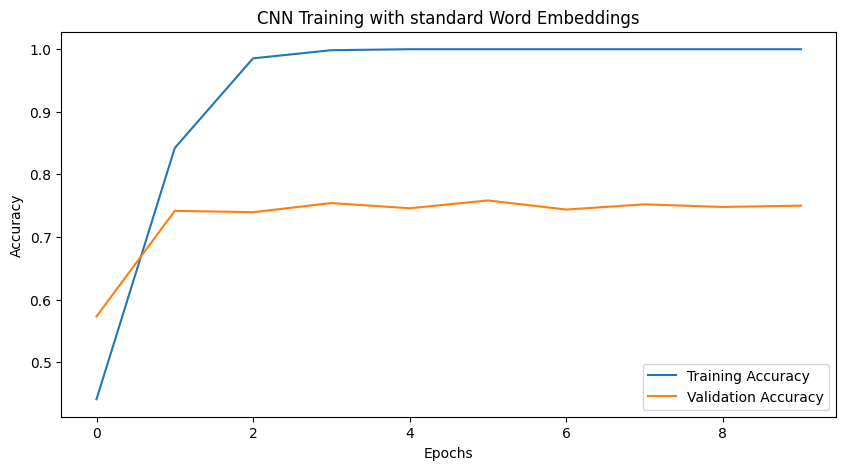

In [25]:
# Convolutional Neural Nentworks (CNN)
model = Sequential()
# Embedding Layer
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=sequence_len))
# Conv. Layer
model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
# Pool
model.add(layers.GlobalMaxPool1D())
# Additional dense layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(np.array(X_train_token), np.array(y_train), epochs=10,
                    validation_split=0.2,
                    batch_size=16,
                    verbose=1)

metrics_df = pd.DataFrame(history.history)
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title('CNN Training with standard Word Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [26]:
# CNN evaluation
loss, accuracy = model.evaluate(np.array(X_train_token), np.array(y_train), verbose=False)
print("Training Accuracy: {:.2f}".format(accuracy))
loss, accuracy = model.evaluate(np.array(X_test_token), np.array(y_test), verbose=False)
print("Testing Accuracy:  {:.2f}".format(accuracy))

Training Accuracy: 0.95
Testing Accuracy:  0.74
